In [1]:
%matplotlib notebook
import os

import jplus
#jplus_dir         =  '/home/CEFCA/aaorsi/work/j-plus/'
elg_analysis_dir  = '/home/CEFCA/aaorsi/work/elg_jplus/'
elgdata           = '%s/out/elgs.dat' % elg_analysis_dir
redmapper_dir     = '/home/CEFCA/aaorsi/work/redmapper/'
redmapperdata     = redmapper_dir + 'redmapper_dr8_public_v6.3_catalog.fits'
#tilesdata         = '%s/tiles/tiles_data_new.tsv' % elg_analysis_dir


cwd = os.getcwd()
import sys

#sys.path.append(jplus_dir)
sys.path.append(elg_analysis_dir)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits

#import elg_analysis as elg
import elgtools as tools_elg
import learn_elgs as learn_elg
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord

tile_scale = 1.40

rmin = -2
rmax =np.log10(tile_scale/2.)
nbins = 20

rarr = np.linspace(rmin, rmax, nbins)
dr = rarr[1] - rarr[0]

#t_info = np.loadtxt(tilesdata) ## Old tile list info, don't use
#print 'tiles info read'
tiles = jplus.datasets.fetch_jplus_tile_list(db='upad',overwrite=False)


j-plus [INFO]: Fetching J-PLUS Tile list
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/objects_tile_list_upad_dual.h5


In [2]:
jplus


<module 'jplus' from '/home/CEFCA/aaorsi/anaconda2/envs/photozenv/lib/python2.7/site-packages/jplus-0.1-py2.7.egg/jplus/__init__.pyc'>

In [39]:
def get_distance(ra1, dec1, ra2, dec2):
  ra1 *= np.pi/180.
  ra2 *= np.pi/180.
  dec1 *= np.pi/180.
  dec2 *= np.pi/180.
  
# Angular distance for two sets of coordinates
  cosg = (np.cos(np.pi/2. - dec1)*np.cos(np.pi/2. - dec2) +
          np.sin(np.pi/2. - dec1)*np.sin(np.pi/2.-dec2)*np.cos(ra1 - ra2))
  
  return np.arccos(cosg)


def quick_dist(ra1, dec1, ra2, dec2, units='deg'):
  return np.sqrt( ((ra1 - ra2)*np.cos(dec1*np.pi/180))**2 + (dec1 - dec2)**2)

def haversine_dist(ra1, dec1, ra2, dec2):
  th1 = np.pi/2. - dec1 * np.pi/180.0
  th2 = np.pi/2. - dec2 * np.pi/180.0

  ph1 = ra1 * np.pi/180.0
  ph2 = ra2 * np.pi/180.0

  dph = np.abs(ph1 - ph2)
  dth = np.abs(th1 - th2)

  harg = np.sin(dph/2)**2 + np.cos(ph1)*np.cos(ph2) * np.sin(dth/2.)**2

  return 2 *np.arcsin(np.sqrt(harg)) * 180./np.pi  # Return distance in degrees


def skydist(ra1,dec1,ra2,dec2, units='deg'):
  
  n2 = len(ra2)

  if n2 != len(dec2):
    raise ValueError('ra, dec arrays have different number of elements')
  
  dist = np.zeros(n2)

  c1 = SkyCoord(ra1,dec1,unit=units)
  for i in range(n2):
    c2 = SkyCoord(ra2[i], dec2[i], unit=units)
    dist[i] = c1.separation(c2).radian

  return dist

def load_catalogues(elgfile = elgdata, centralobj = redmapperdata, centralobjtype = 'fits', 
                    zrange=[.3,.35]):


# Function to load elgs and redmapper catalogues

  elgs = pickle.load(open(elgfile))
  print 'ELG catalogue loaded'

  if centralobjtype == 'fits':
    raw_central = fits.open(centralobj)
    central0     = raw_central[1].data
    zsel = np.where((central0['z_lambda'] > zrange[0]) & (central0['z_lambda'] < zrange[1]))[0]
    ncentral = len(zsel)
    central = central0[zsel]
  else:
    central = centralobj
    ncentral = len(central['ra'])
    zsel     = np.arange(ncentral)

  
  return {'elgs':elgs, 'central':central}

  
def get_density(datadic, tiles, weights, dfunc = haversine_dist):  
  
  gal_arr = np.zeros(nbins)
  central = datadic['central']
  elgs    = datadic['elgs']
  ncentral  = len(central['ra'])
    
  # dfunc = quick_dist  # Define which distance calculator to use
  # dfunc = haversine_dist # get_distance  # Define which distance calculator to use
  
  print 'central objects loaded, %d clusters' % ncentral

  # Select only those central objects 
  # near a J-PLUS tile
  
  
  elgtiles = np.unique(elgs['tile_id'])
        
  ntiles = len(elgtiles)
  print 'ELG sample is contained in %d tiles' % ntiles
  print 'scanning tiles..'
 
  ktot = 0
  wtot = 0.0
  for i in range(ncentral):
    idc = i

    dist = dfunc(central['ra'][idc], central['dec'][idc], tiles['ra'], 
                tiles['dec'])
    idist = np.argmin(dist)
    mindist = dist[idist]

    if mindist < tile_scale:
      idtt = np.where(elgtiles == tiles['tileIDs'][idist])[0] # Tile with central obj contains ELGs
      
      if len(idtt) != 1:
        continue # len(idtt) = 0 would mean that this tile is empty -- not observed or bad photometry

      iw = weights[idist]  
      sel_tile = np.where(elgs['tile_id'] == tiles['tileIDs'][idist])[0]
      ngals = len(sel_tile)
  
      ktot += 1.0 # Tile contains central galaxy + ELGs around it.
      wtot += iw
      for k in range(ngals):
        idg = sel_tile[k]
        dist = np.log10(dfunc(central['ra'][idc], central['dec'][idc], 
        elgs['coords'][idg,0], elgs['coords'][idg,1]))

        if dist < rmax:
          dbin = int((dist  - rmin)/dr)
          gal_arr[dbin:] += iw

#    if ktot == 79:
#      break

  print gal_arr/ktot/wtot

  print 'N centers: ',ktot
  return gal_arr/ktot


def plot_densities(d1,label):
  import matplotlib.pyplot as plt
  vol_r = 1 #np.pi*(10**rarr)**2

  for d, l in zip(d1, label):
      plt.semilogy(rarr, d/vol_r,label=l,linewidth=3)

  plt.legend(fontsize=20, loc='upper left')

  plt.xlabel(r'$\log(\theta [{\rm deg}])$',fontsize=20)
  plt.ylabel(r'$\langle n \rangle (\leq r) [{\rm deg}^{-2}]$',fontsize=20)

  plt.xlim([rarr.min(),rarr.max()])
  #plt.ylim([np.min([d1v,d2v]), d2v.max()])

  plt.show()

  return 1


In [70]:

#def elg_clusters():

CreateRandoms = False # False implies reading them from a file
RanFile = 'random_mask'

mastercat = load_catalogues()
tcenter = {'ra':tiles['ra'], 'dec':tiles['dec']}
tilecat = load_catalogues(centralobj=tcenter, centralobjtype='')


elgs = mastercat['elgs']
import pymangle

tiles = jplus.datasets.fetch_jplus_tile_list(db='upad',overwrite=False)
stars = jplus.datasets.fetch_jplus_objects_to_mask(db='upad',overwrite=False)
mask  = jplus.mangle.Mask(tiles,stars, overwrite=False)


if CreateRandoms:
    print 'Creating random mask file...'
    ran = mask.create_random(3e5)
    nran = len(ran['coords'])
    print 'Nrandom: %ld' % nran
    ran_tile_id = np.zeros(nran)
    
    print 'finding tile_id of random points...'
    for i in range(nran):
        rc = ran['coords']
        dist = haversine_dist(rc[i,0], rc[i,1], tiles['ra'], 
                tiles['dec'])
        idist = np.argmin(dist)
        mindist = dist[idist]
        ran_tile_id[i] = tiles['tileIDs'][idist]
    print 'done'

    randict = {'coords':ran['coords'], 'tile_id':ran_tile_id}    

    with open(RanFile,'wb') as outfile:
        pickle.dump(randict,outfile,protocol=pickle.HIGHEST_PROTOCOL)
else:
    print 'Reading random mask file ...'
    randict = pickle.load(open(RanFile))
    
                
good = mask.contains(elgs['coords'])


mask_clusters = {}  # Mask density around ELGs
mask_clusters['elgs'] = randict
mask_clusters['central'] = mastercat['central']


mask_tile = {}
mask_tile['elgs'] = randict
mask_tile['central'] = tilecat['central']


  

j-plus [INFO]: Fetching J-PLUS Tile list
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/objects_tile_list_upad_dual.h5
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_objects_to_mask_upad_dual.h5
j-plus [INFO]: Reading Mangle Mask /home/CEFCA/aaorsi/photoz/jplus_data/mask_data/jplus_mask.pol
j-plus [INFO]: Creating random points


ELG catalogue loaded
ELG catalogue loaded
Creating random mask file...
Nrandom: 300000
finding tile_id of random points...
done


In [71]:
randict
#a = pickle.load(RanFile)
RanFile
randict.keys()

['tile_id', 'coords']

j-plus [INFO]: Creating HealPix map
j-plus [INFO]: Saving HealPix map /home/CEFCA/aaorsi/photoz/jplus_data//hmap_256.fits
j-plus [INFO]: Reading HealPix map /home/CEFCA/aaorsi/photoz/jplus_data//hmap_256.fits
j-plus [INFO]:  Plotting in the range: lon = [-179.997138236,173.276598894], and lat = [1.15049210624,79.8822477602]


<IPython.core.display.Javascript object>


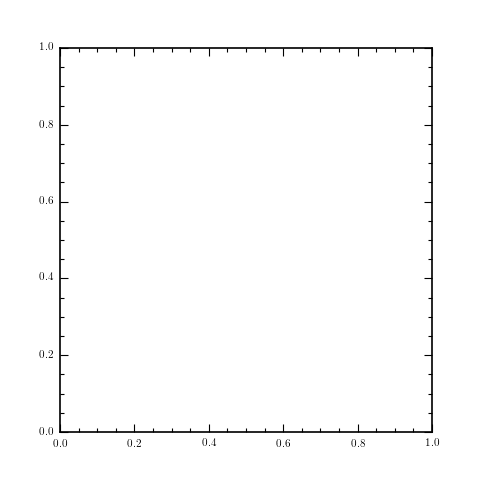

<IPython.core.display.Javascript object>


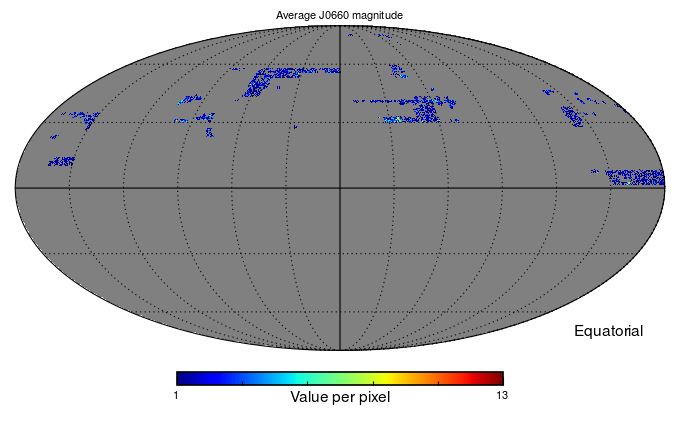

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [72]:
hp = jplus.healpix.HealpixMap(elgs['coords'][:,:], average=False, nside=256)#, value=obj_jplus['rJAVA'][good,0])
hmap = hp.plot(interactive=False, title="Average J0660 magnitude")

j-plus [INFO]: Creating HealPix map
j-plus [INFO]: Saving HealPix map /home/CEFCA/aaorsi/photoz/jplus_data//hmap_256.fits
j-plus [INFO]: Reading HealPix map /home/CEFCA/aaorsi/photoz/jplus_data//hmap_256.fits
j-plus [INFO]:  Plotting in the range: lon = [-179.999946153,179.999748071], and lat = [1.17337374058,79.8743965287]


<IPython.core.display.Javascript object>


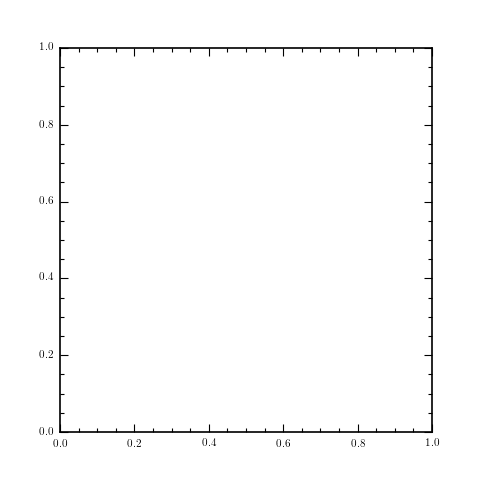

<IPython.core.display.Javascript object>


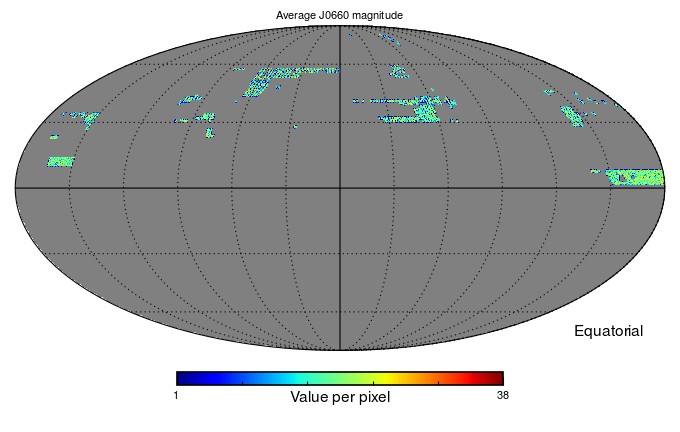

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [73]:
hp = jplus.healpix.HealpixMap(randict['coords'][:,:], average=False, nside=256)#, value=obj_jplus['rJAVA'][good,0])
hmap = hp.plot(interactive=False, title="Average J0660 magnitude")

In [13]:
print g4

NameError: name 'g4' is not defined

<IPython.core.display.Javascript object>


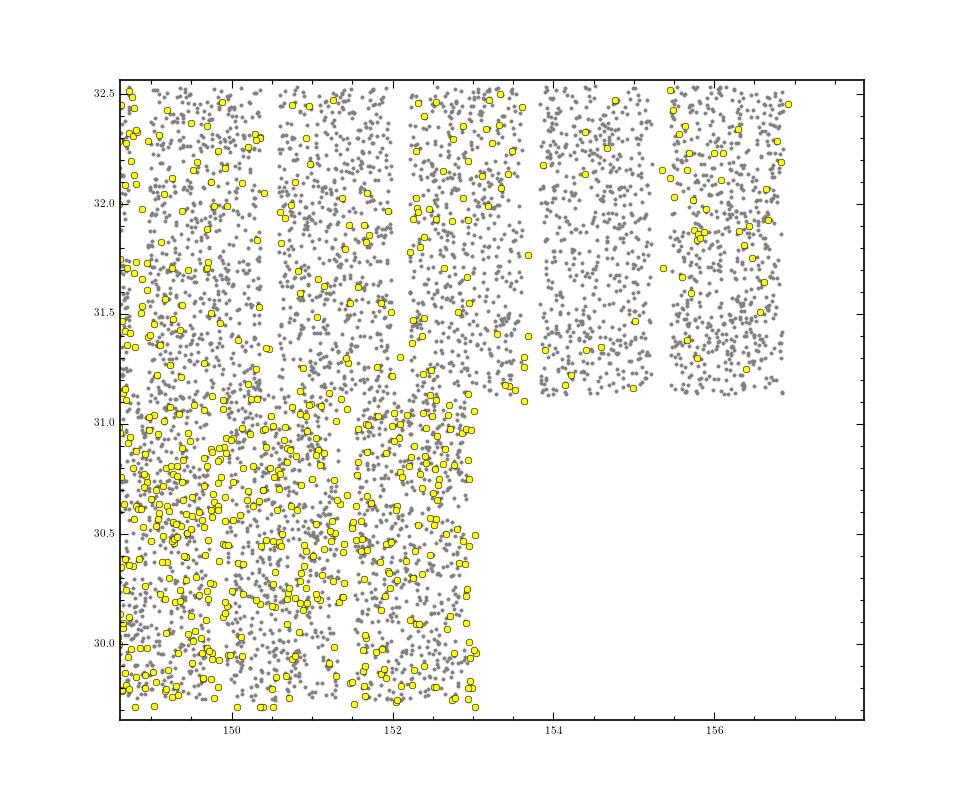

In [74]:
plt.figure(12)
plt.plot(randict['coords'][:,0],randict['coords'][:,1], '.',color='gray')
plt.plot(elgs['coords'][:,0],elgs['coords'][:,1], 'o',color='yellow')
plt.show()



Number of tiles available: 6338
Number of tiles in groupby: 523


<IPython.core.display.Javascript object>


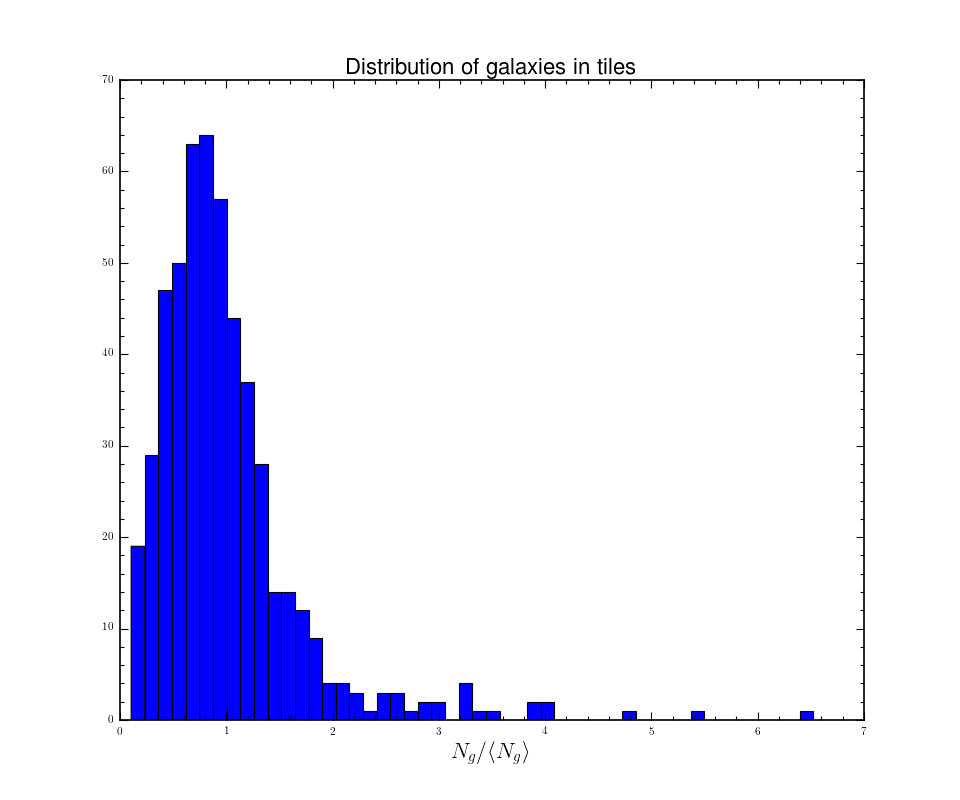

In [75]:
tile, mag, total = jplus.plotting.groupbytile(elgs['tile_id'], elgs['J0660'][:,0])
#print tile
#print mag
#print total

weights = np.asarray(total)/(np.mean(total)+0.0)
#print weights
ntile = len(tiles['tileIDs'])
#print tiles['tileIDs']

wtile = np.zeros(ntile)
k = 0
for itile in tiles['tileIDs']:
    idd = np.where(tile == itile)[0]
    if len(idd) == 1:
        wtile[k] = 1./weights[idd]
    else:
        wtile[k] = 0.0
    k +=1

#print wtile
#print len(np.where(wtile == 0)[0])/(ntile+0.0)

print 'Number of tiles available: %ld' % ntile
print 'Number of tiles in groupby: %ld' % len(tile)

plt.figure(666)

plt.hist(weights,bins=50)
plt.xlabel(r'$N_g/\langle N_g \rangle',fontsize=20)
plt.title('Distribution of galaxies in tiles',fontsize=20)



In [76]:


g1 = get_density(mastercat, tiles, wtile)
g2 = get_density(tilecat, tiles, wtile)

g3 = get_density(mask_clusters, tiles, wtile)
g4 = get_density(mask_tile, tiles, wtile)



central objects loaded, 3650 clusters
ELG sample is contained in 523 tiles
scanning tiles..
[ 0.          0.          0.00034429  0.00034429  0.00034429  0.00034429
  0.00303522  0.00366479  0.00605206  0.00805188  0.01189755  0.02314659
  0.03309947  0.04010591  0.06102473  0.08805375  0.11779459  0.17729237
  0.25969285  0.25969285]
N centers:  39.0
central objects loaded, 6338 clusters
ELG sample is contained in 523 tiles
scanning tiles..
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   8.46941634e-05
   8.46941634e-05   1.30523366e-04   2.93544386e-04   5.73391876e-04
   7.52326210e-04   1.01236346e-03   1.49272991e-03   2.62140641e-03
   3.59815614e-03   5.87265869e-03   9.36925806e-03   1.39936253e-02
   2.15853187e-02   3.34073267e-02   4.61331478e-02   4.61331478e-02]
N centers:  455.0
central objects loaded, 3650 clusters
ELG sample is contained in 529 tiles
scanning tiles..
[  3.25024896e-05   1.80029579e-04   3.51166591e-04   5.38803090e-04
   1.04882722e-03   1.7315707

<IPython.core.display.Javascript object>


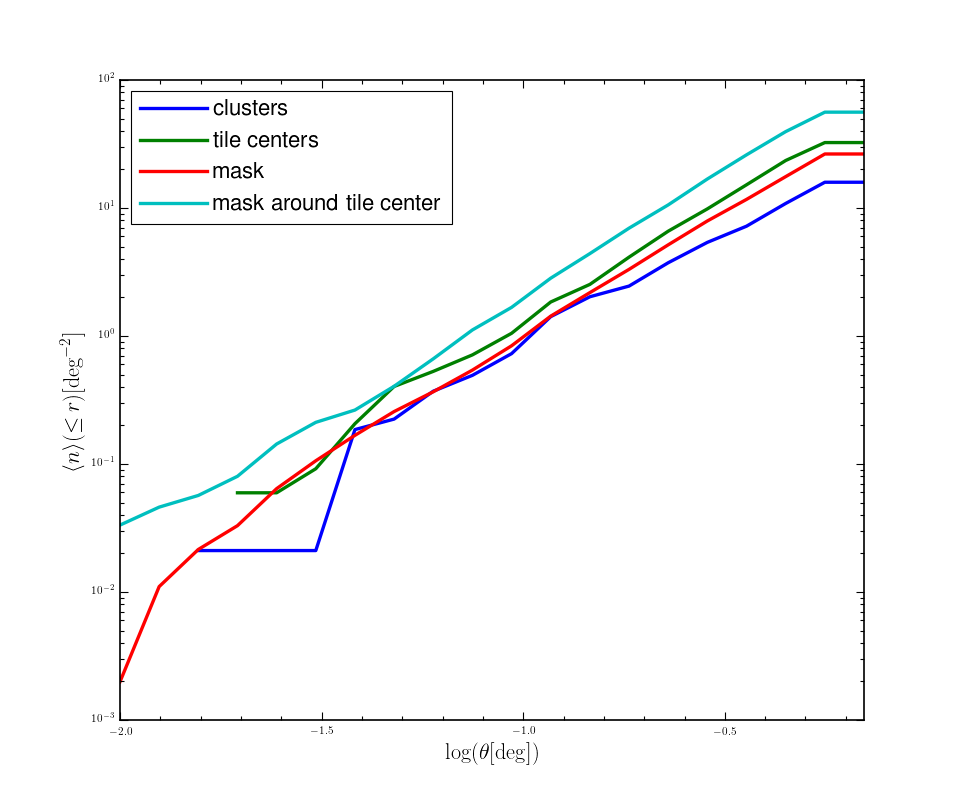

<IPython.core.display.Javascript object>


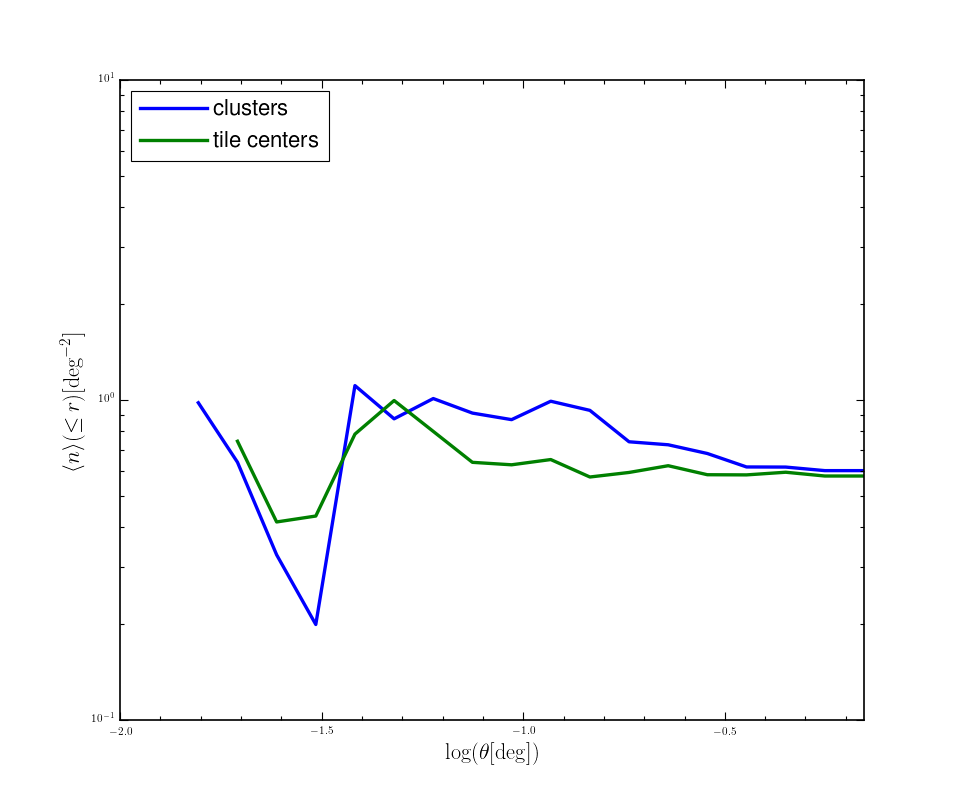

1

In [77]:
plt.figure(11)
plot_densities([g1,g2,g3,g4],['clusters','tile centers', 'mask', 'mask around tile center'])
plt.figure(22)
plot_densities([g1/g3,g2/g4],['clusters','tile centers'])

<IPython.core.display.Javascript object>


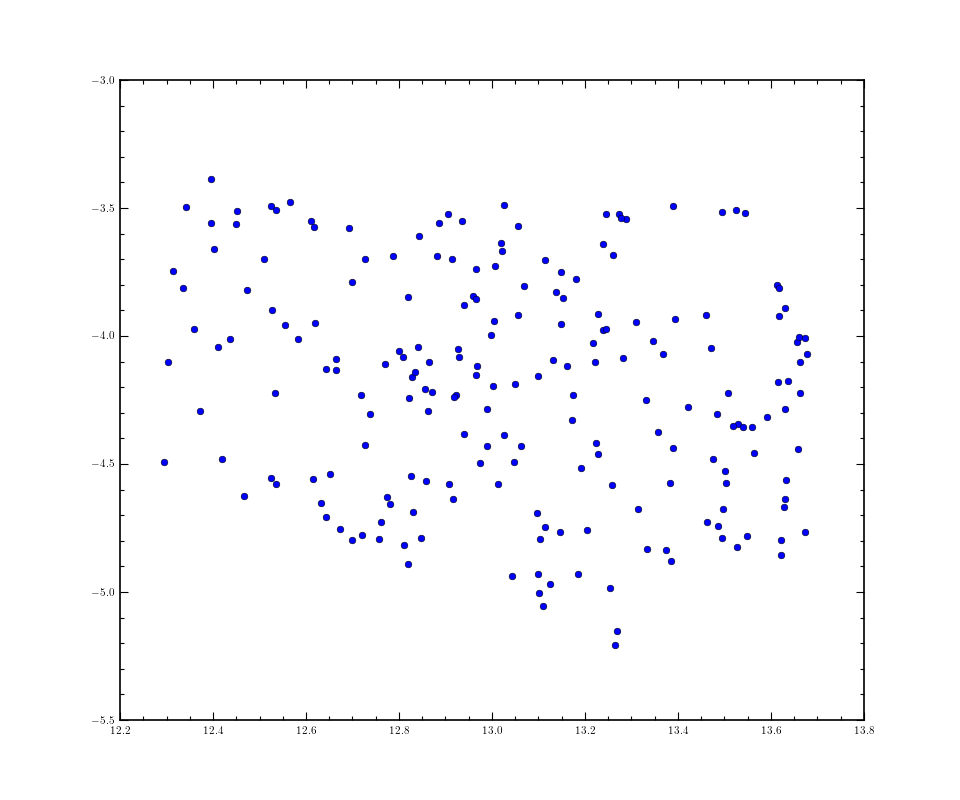

26003
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  T

In [29]:
plt.figure()

tnumber = 0
tid = tiles['tileIDs'][tnumber]
print tid
mask = randict['tile_id'] == randict['tile_id'][0]
print mask[mask == True]
plt.plot(ran['coords'][mask,0]-tiles['ra'][tnumber],ran['coords'][mask,1]-tiles['dec'][tnumber],'o')

<IPython.core.display.Javascript object>


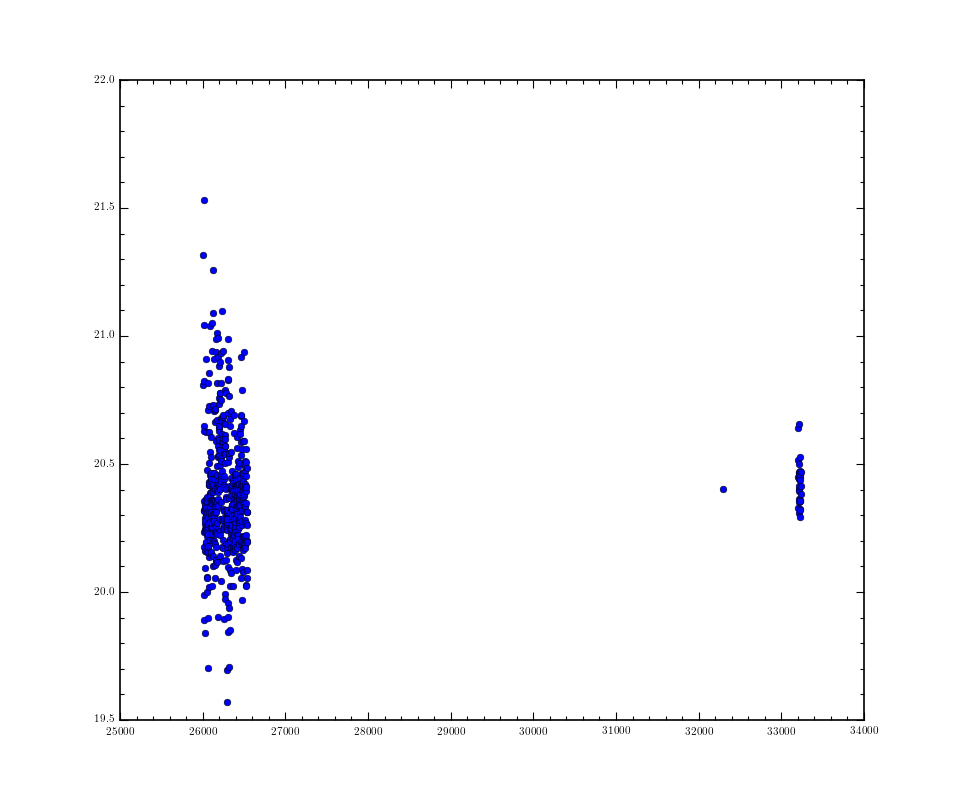

[33204, 33205, 33206, 33207, 33208, 33209, 33210, 33211, 33212, 33213, 33214, 33215, 33216, 33217, 33218, 33219, 33220, 33221, 33222, 33223, 33224, 33225, 33226, 33227, 33228, 33230, 33231, 33232, 33233, 33234, 32300, 25998, 26010, 26011, 26012, 26013, 26014, 26015, 26016, 26017, 26018, 26019, 26020, 26021, 26022, 26023, 26024, 26025, 26026, 26028, 26029, 26030, 26031, 26032, 26033, 26034, 26035, 26036, 26037, 26038, 26039, 26040, 26041, 26042, 26043, 26044, 26045, 26047, 26048, 26049, 26050, 26051, 26052, 26053, 26054, 26055, 26056, 26057, 26058, 26059, 26060, 26061, 26062, 26063, 26064, 26065, 26066, 26067, 26068, 26069, 26070, 26071, 26072, 26073, 26074, 26075, 26076, 26077, 26079, 26080, 26081, 26082, 26083, 26084, 26085, 26087, 26088, 26089, 26090, 26091, 26092, 26093, 26094, 26095, 26096, 26097, 26098, 26099, 26100, 26101, 26102, 26103, 26104, 26105, 26106, 26107, 26108, 26109, 26110, 26111, 26112, 26113, 26115, 26119, 26121, 26122, 26123, 26124, 26125, 26126, 26127, 26128, 26129

In [30]:
tile, mag, total = jplus.plotting.groupbytile(elgs['tile_id'], elgs['J0660'][:,0])
plt.figure()
plt.plot(tile, mag,'o')
print tile, total

In [ ]:
len(elgs['tile_id'])
